# Exercise 2: Linear wave equation in 2D
### Manuel Luis Alcázar Laynez

# License
    IPython notebook for simulating the linear wave equation with OpenCL
    Copyright (C) 2021 manlu.tomcat@gmail.com

    This program is free software: you can redistribute it and/or modify
    it under the terms of the GNU General Public License as published by
    the Free Software Foundation, either version 3 of the License, or
    (at your option) any later version.

    This program is distributed in the hope that it will be useful,
    but WITHOUT ANY WARRANTY; without even the implied warranty of
    MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
    GNU General Public License for more details.

    You should have received a copy of the GNU General Public License
    along with this program.  If not, see <http://www.gnu.org/licenses/>.

In [8]:
#Lets have matplotlib "inline"
%pylab inline

#Lets have opencl ipython integration enabled
%load_ext pyopencl.ipython_ext

#Import packages we need
import numpy as np
import pyopencl as cl
from matplotlib import pyplot as plt

#Make sure we get compiler output from OpenCL
import os
os.environ["PYOPENCL_COMPILER_OUTPUT"] = "1"

Populating the interactive namespace from numpy and matplotlib
The pyopencl.ipython_ext extension is already loaded. To reload it, use:
  %reload_ext pyopencl.ipython_ext


In [9]:
#Create OpenCL context
cl_ctx = cl.create_some_context()

#Create an OpenCL command queue
cl_queue = cl.CommandQueue(cl_ctx)

# Linear wave equation in 2D


## Example: Heat equation in 2D
As an example, the heat equation in 2D can be written
$$
\begin{align}
\frac{\partial u}{\partial t} &= \kappa \nabla^2 u\\
&= \kappa \left [ \frac{\partial^2 u}{\partial x^2} + \frac{\partial^2 u}{\partial y^2} \right ]
\end{align}
$$
And equivalently, we end up with
$$
u^{n+1}_{i,j} = u_{i,j}^n + \kappa \frac{\Delta t}{\Delta x^2}(u_{i-1,j}^n - 2u_{i,j}^n + u_{i+1,j}^n) 
+ \kappa \frac{\Delta t}{\Delta y^2}(u_{i,j-1}^n - 2u_{i,j}^n + u_{i,j+1}^n)
$$

This discretization is unstable if the following CFL condition is not met
$$
\frac{1}{2} \gt \frac{\kappa\Delta t}{\Delta x^2};\frac{1}{2} \gt \frac{\kappa\Delta t}{\Delta y^2}
$$
or 
$$
\Delta t \lt min \left ( \frac{\Delta x^2}{2\kappa}, \frac{\Delta y^2}{2\kappa} \right )
$$

## 2D Linear wave equation implementation
The linear wave equation can be written

$$
\begin{align}
\frac{\partial^2 u}{\partial^2 t} &= c \nabla^2 u\\
&= c \left [ \frac{\partial^2 u}{\partial x^2} + \frac{\partial^2 u}{\partial y^2} \right ]
\end{align}
$$

where $u$ is the value of the wave in $(x,y)$, and $c$ is the wave propagation speed coefficient. 

We can discretize the equation as

$$
\frac{1}{\Delta t^2} (u_{i,j}^{n+1} - 2u_{i,j}^{n} + u_{i,j}^{n-1}) = \frac{c}{\Delta x^2}(u_{i-1,j}^n - 2u_{i,j}^n + u_{i+1,j}^n) + \frac{c}{\Delta y^2}(u_{i,j-1}^n - 2u_{i,j}^n + u_{i,j+1}^n)
$$

and gathering $u^n+1$ on the left hand side and $u^n$ and $u^{n-1}$ on the right, we write

$$
u_{i,j}^{n+1} = 2u_{i,j}^{n} - u_{i,j}^{n-1} + \frac{c \Delta t^2}{\Delta x^2}(u_{i-1,j}^n - 2u_{i,j}^n + u_{i+1,j}^n) + \frac{c \Delta t^2}{\Delta y^2}(u_{i,j-1}^n - 2u_{i,j}^n + u_{i,j+1}^n)
$$

This discretization is unstable if the following CFL condition is not met
$$
\frac{1}{2} \gt \frac{c\Delta t}{\Delta x};\frac{1}{2} \gt \frac{c \Delta t}{\Delta y}
$$
or 
$$
\Delta t \lt min \left ( \frac{\Delta x}{2 c}, \frac{\Delta y}{2 c} \right )
$$

In [10]:
%%cl_kernel 
__kernel void linear_wave_eq_2D(__global float *u2, __global float *u1, __global const float *u0, float c, float dt, float dx, float dy) {
    //Get total number of cells
    int nx = get_global_size(0);
    int ny = get_global_size(1);
    int i = get_global_id(0);
    int j = get_global_id(1);
    
    //Indices of each neighboring cell:
    int center = j*nx + i;
    int north  = (j+1)*nx + i;
    int south  = (j-1)*nx + i;
    int east   = j*nx + (i+1);
    int west   = j*nx + (i-1);
    
    //Internal cells
    if (i > 0 && i < nx-1 && j > 0 && j < ny-1)
    {
        //Note: u2 = u^(n+1);u1 = u^(n);u0 = u(n-1)
        u2[center] = 2*u1[center] - u0[center]
                   + c*dt*dt/(dx*dx) * (u1[west] - 2*u1[center] + u1[east])
                   + c*dt*dt/(dy*dy) * (u1[south]- 2*u1[center] + u1[north]);
    }
    //Boundary conditions (ghost cells): Simulating perfect wall reflection
    if (i == 0) {
        u2[center] = u2[east];
    }
    else if (i == nx-1) {
        u2[center] = u2[west];
    }
    else if (j == 0) {
        u2[center] = u2[north];
    }
    else if (j == ny-1) {
        u2[center] = u2[south];
    }

}

For using the same structure as the given example notebook for heat equation in 1 dimension, we will implement the two dimensional equations but maintaining the classes and the main code structure.

In [11]:
"""
Class that holds data for the linear wave equation in OpenCL
"""
class LinearWaveDataCL:
    """
    Uploads initial data to the CL device
    """
    def __init__(self, u0):
        #Make sure that the data is single precision floating point
        assert(np.issubdtype(u0.dtype, np.float32))
        
        #Find number of cells
        self.nx, self.ny = u0.shape
        
        mf = cl.mem_flags 
        
        #Upload data to the device
        self.u0 = cl.Buffer(cl_ctx, mf.READ_WRITE | mf.COPY_HOST_PTR, hostbuf=u0)
        
        #Allocate output buffers
        self.u1 = cl.Buffer(cl_ctx, mf.READ_WRITE, u0.nbytes)
        self.u2 = cl.Buffer(cl_ctx, mf.READ_WRITE, u0.nbytes)
        
    """
    Enables downloading data from CL device to Python
    """
    def download(self):
        #Allocate data on the host for result
        u1 = np.empty((self.nx, self.ny), dtype=np.float32)
        
        #Copy data from device to host
        cl.enqueue_copy(cl_queue, u1, self.u1)
        
        #Return
        return u1;

In [12]:
"""
Computes the heat equation using an explicit finite difference scheme with OpenCL
"""
def opencl_linear_wave_eq(cl_data, c, dx, dy, nt):
    #Calculate dt from the CFL condition
    dt = 0.4 * min(dx/(2.0*c), dy/(2.0*c))

    #Loop through all the timesteps
    for i in range(nt):
        #Execute program on device
        linear_wave_eq_2D(cl_queue, (cl_data.nx, cl_data.ny), None, cl_data.u2, cl_data.u1, cl_data.u0, numpy.float32(c), numpy.float32(dt), numpy.float32(dx), numpy.float32(dy))
        
        #Swap variables
        cl_data.u0, cl_data.u1, cl_data.u2 = cl_data.u1, cl_data.u2, cl_data.u0

0.0


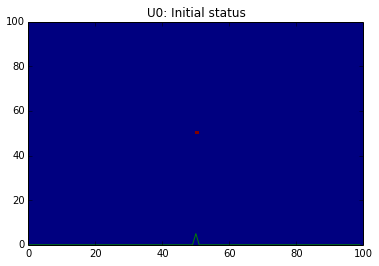

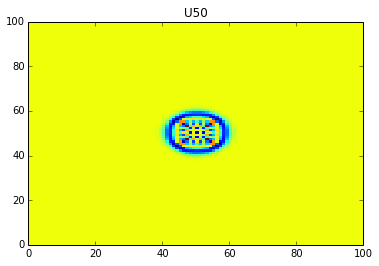

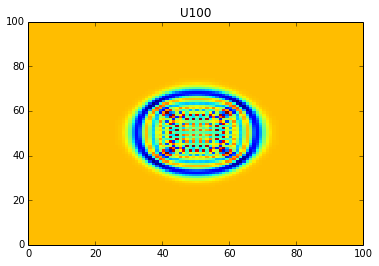

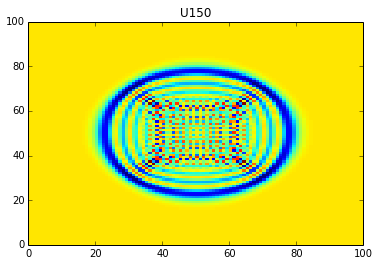

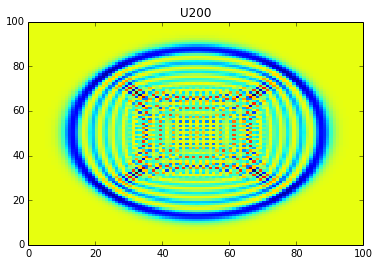

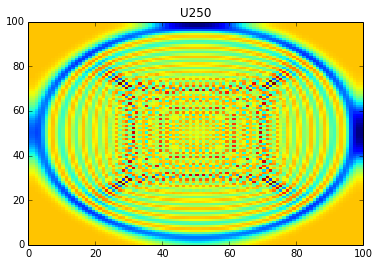

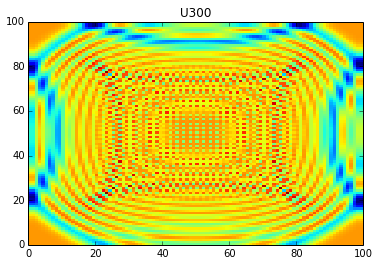

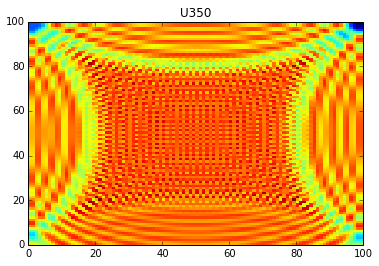

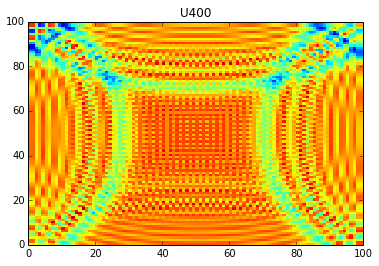

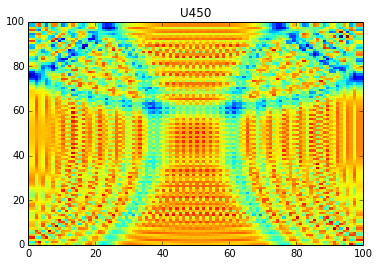

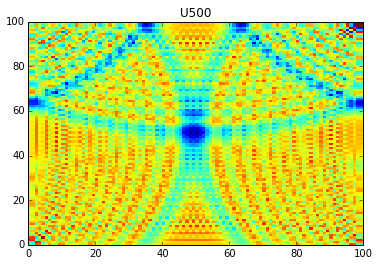

In [13]:
#Create test input data
nx = 100
ny = nx

#u0 = np.random.rand(nx, ny).astype(np.float32)
u0 = np.zeros((nx, ny)).astype(np.float32)
u0[nx/2, ny/2] = 5
print(u0[0,0])
cl_data = LinearWaveDataCL(u0)
c = 1.0
dx = 1.0
dy = 1.0

#Plot initial conditions
figure()
plot(u0, label="u0")

# We want 500 steps, and a plot each 50 steps:
nt = 10
timesteps_per_plot=50
# total steps = nt* timesteps_per_plot = 500

plt.pcolormesh(u0)
plt.draw()
plt.title("U0: Initial status")
plt.show()

for i in range(0, nt):
    #Simulate nt timesteps
    opencl_linear_wave_eq(cl_data, c, dx, dy, timesteps_per_plot)

    #Download data
    u2 = cl_data.download()

    #Plot
    plt.pcolormesh(u2)
    plt.title("U%d"%((i+1)*timesteps_per_plot))
    plt.draw()

    plt.show()
#legend()